# Sentiment Analysis

#### Sentiment analysis is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.<br>

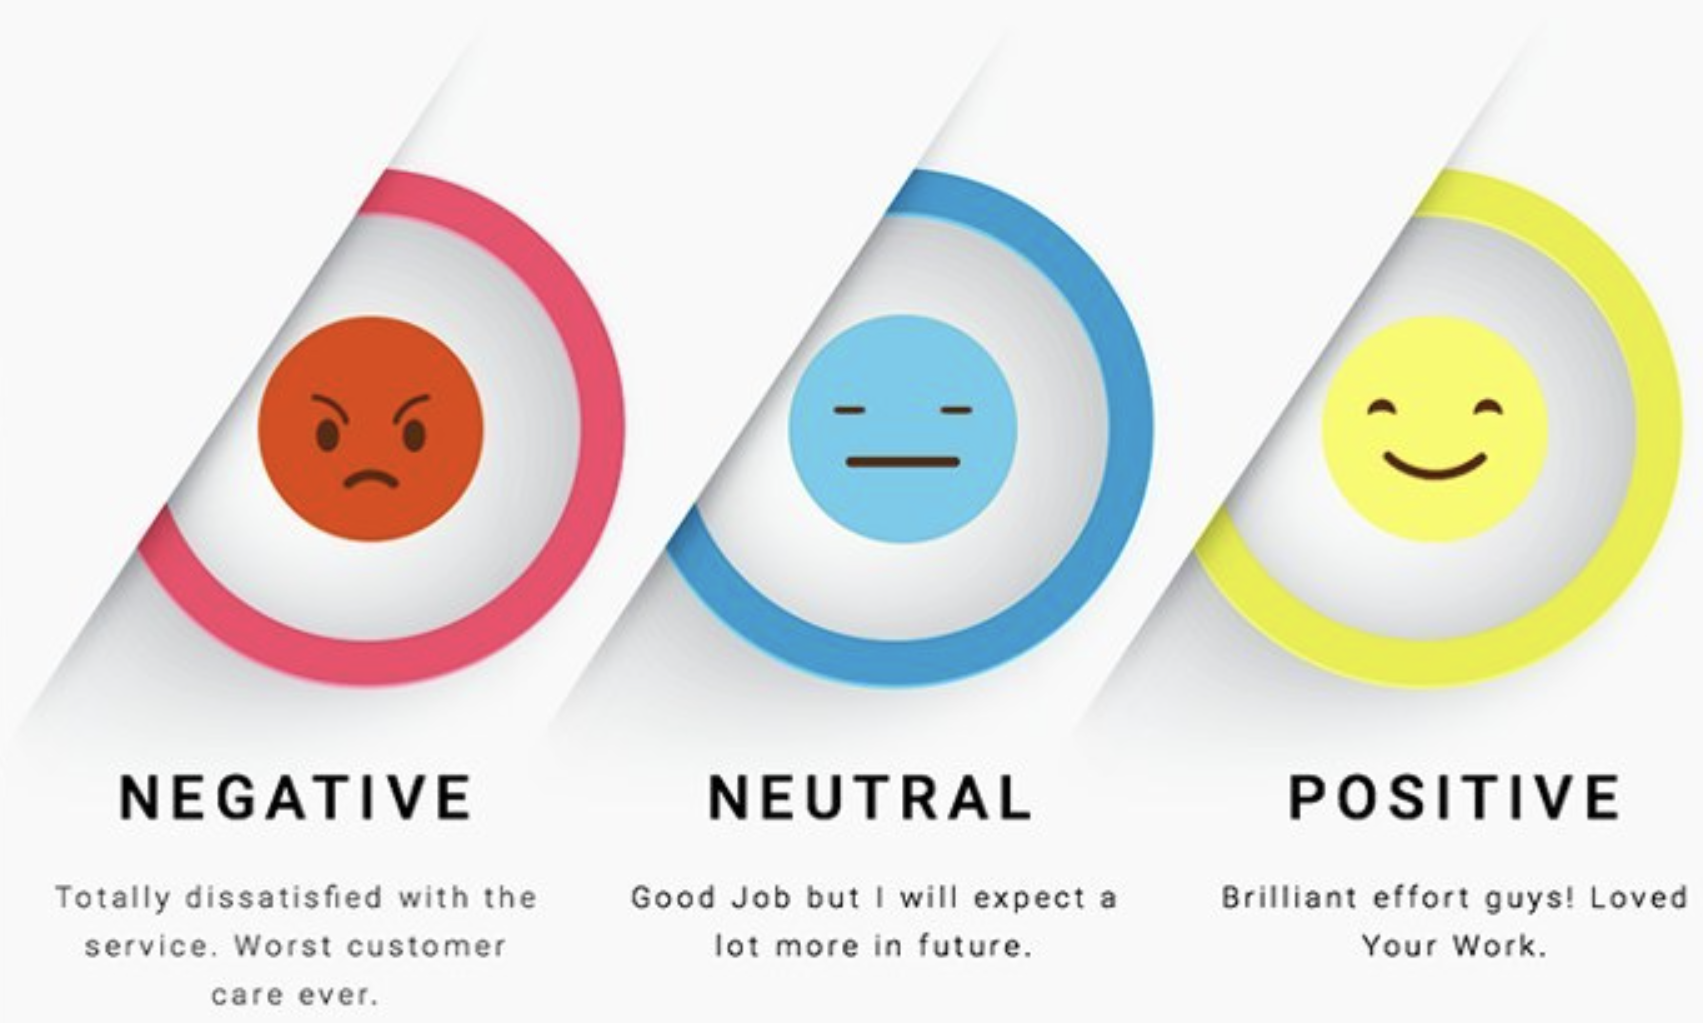

#### Dataset used consists of the following features
| Feature | Description |
| --- | --- |
| target | the polarity of the tweet (0 = negative, 4 = positive)|
| ids | The id of the tweet ( 2087) |
| date | the date of the tweet (Sat May 16 23:58:44 UTC 2009) |
| flag | The query (lyx). If there is no query, then this value is NO_QUERY. |
| user | the user that tweeted (robotickilldozr) |
| text | the text of the tweet (Lyx is cool) |

## Importing Data

In [18]:
import pandas as pd
import numpy as np

In [19]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)
df.columns = ['Target', 'ID', 'Date', 'Flag', 'User', 'Text']
df = df[['Target', 'Text']]

In [20]:
df.head()

In [21]:
df.isna().sum()

In [22]:
df.nunique()

#### Changing Target from 4 to 1 for positive texts for ease of understanding

In [23]:
df['Target'] = df['Target'].apply(lambda x: x**0 if(x==4) else 0)

In [24]:
df['Target'].unique()

#### Subsetting Data

In [25]:
data_pos = df[df['Target'] == 1].iloc[:int(10000)]
data_neg = df[df['Target'] == 0].iloc[:int(10000)]
df = pd.concat([data_pos, data_neg])
df.reset_index(drop=True, inplace=True)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Visualizing Target proportions

In [27]:
ax = sns.countplot(x=df['Target'])
for p in ax.patches:
    ax.annotate('{:.1f}  ({:.1f}%)'.format(p.get_height(),(p.get_height()/len(df)*100)),
                (p.get_x()+.175, p.get_height()+(p.get_height()*0.01)))
plt.show()

## Pre-processing Data

In [28]:
import nltk
#nltk.download()
import string as st
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
import re
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [29]:
corpus = df['Text'].tolist()
len(corpus)

#### Function below first removes all the urls and then removes stopwords and punctuations from corpus sentences tokenized by words

In [30]:
stemmer = LancasterStemmer()
final_corpus = []
for i in tqdm_notebook(range(len(corpus))):
    word = re.sub('((www[^\s]+)|(http[^\s]+))',' ',corpus[i].lower())
    word = word_tokenize(word)
    word = [stemmer.stem(y) for y in word if y not in (list(stopwords.words('english'))+list(st.punctuation))]
    j = " ".join(word)
    final_corpus.append(j)

In [31]:
data = pd.DataFrame(final_corpus)
data.columns = ['Text']
data['Target'] = df['Target']

In [32]:
data.head()

## Visualizing positive and negative texts

In [33]:
from wordcloud import WordCloud

In [51]:
def wordcloud_draw(data, color, title):
    words = ' '.join(data)
    wordcloud = WordCloud(background_color='white',width=2500,height=2000).generate(words)
    plt.figure(figsize=(7, 7))
    plt.imshow(wordcloud)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

wordcloud_draw(data['Text'][data['Target']==1],'white','Positive words')
wordcloud_draw(data['Text'][data['Target']==0], 'white', 'Negative words')

## Model

#### Extracting TF-IDF features

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
data.to_csv('data.csv',index=False)

In [37]:
tf_idf = TfidfVectorizer()
x_train = tf_idf.fit_transform(data['Text'])
y_train= data['Target']

In [38]:
x_train = x_train.toarray()

#### Splitting data and training Decision Tree, Random Forest and Linear SVC

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

In [41]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth =3, random_state = 42)
tree.fit(X_train, y_train)

tree_pred = tree.predict(X_test)

In [42]:
from sklearn.ensemble import RandomForestClassifier
rtree = RandomForestClassifier(n_estimators = 100) 
rtree.fit(X_train, y_train)

rtree_pred = rtree.predict(X_test)

In [43]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

lsvc_pred = lsvc.predict(X_test)

## Evaluating Models

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [45]:
def plot(y_pred):
    print("Accuracy of tree model: {}".format(accuracy_score(y_test, y_pred))+"\n\n")
    print("Classification report of tree model: \n{}".format(classification_report(y_test, y_pred))+"\n\n")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="")

In [46]:
plot(tree_pred)

In [47]:
plot(rtree_pred)

In [48]:
plot(lsvc_pred)

### Model Comparison

|Model|Accuracy|
|--|--|
|Decision Tree|0.53|
|Random Forest|0.72|
|Linear SVC|0.72|

Random Forest and Linear SVC both have nearly identical performance.